# Welcome to the Craigstimate Notebook

This notebook covers the full process of building a random forest regressor model using a dataset that scraped all craigslist listings in June of 2020. What is covered in this notebook is provided below
- Preliminary data exploration
- Some feature removals
- Outlier removal
- Dimensionality  reductions
- Basic visualizations
- One Hot Encoding and Column Transformation
- Train, Test, Split with simple model building using linear regression
- Gridsearch with a battery of ML models from sklearn
- Gridsearch again with hypertuning parameters with just Random Forest Regresion
- Metric validation with standard regression metrics (MSE,MAE,R^2,RMSE,Adjusted R^2)
- Exporting categorical features to json and cleaned data
- Pipeline creation with full datset and best parameters from Random Forest gridsearch
- Basic Predictions with Pipeline
- Building a predict function that can take in user input
- Exporting the Pipeline as a pickle file
- Conclusions, Limitations, and Final Thoughts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Data Exploration - A First Look at the Data

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.shape

(384977, 22)

In [4]:
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca
2,7043634882,https://reno.craigslist.org/apa/d/sparks-state...,reno / tahoe,https://reno.craigslist.org,1813,apartment,1683,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00t0t_erYqC6LgB8...,2BD | 2BA | 1683SQFTDiscover exceptional servi...,39.6269,-119.708,ca
3,7049045324,https://reno.craigslist.org/apa/d/reno-1x1-fir...,reno / tahoe,https://reno.craigslist.org,1095,apartment,708,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00303_3HSJz75zlI...,MOVE IN SPECIAL FREE WASHER/DRYER WITH 6 OR 12...,39.4477,-119.771,ca
4,7049043759,https://reno.craigslist.org/apa/d/reno-no-long...,reno / tahoe,https://reno.craigslist.org,289,apartment,250,0,1.0,1,...,1,0,1,laundry on site,NaN,https://images.craigslist.org/01616_fALAWFV8zQ...,"Move In Today: Reno Low-Cost, Clean & Furnishe...",39.5357,-119.805,ca


In [5]:
df.state.value_counts()

ca    33085
fl    31929
tx    31137
nc    18628
mi    14529
ga    13841
oh    12884
tn    11541
co    11308
va    11063
ny     9991
sc     9932
pa     9911
il     9706
al     8196
or     8079
ks     7910
ia     7488
mn     7468
md     7451
la     7304
wa     7061
az     6753
wi     6646
in     6416
ok     5788
nj     5711
ky     5419
ut     5194
ms     4973
ma     4926
id     4466
ct     3765
nd     3428
ar     3149
nm     2917
nv     2846
ne     2697
dc     2502
ak     2169
mo     2158
de     2048
ri     1889
hi     1840
sd     1782
nh     1761
mt     1339
wv      819
vt      527
me      420
wy      187
Name: state, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384977 entries, 0 to 384976
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       384977 non-null  int64  
 1   url                      384977 non-null  object 
 2   region                   384977 non-null  object 
 3   region_url               384977 non-null  object 
 4   price                    384977 non-null  int64  
 5   type                     384977 non-null  object 
 6   sqfeet                   384977 non-null  int64  
 7   beds                     384977 non-null  int64  
 8   baths                    384977 non-null  float64
 9   cats_allowed             384977 non-null  int64  
 10  dogs_allowed             384977 non-null  int64  
 11  smoking_allowed          384977 non-null  int64  
 12  wheelchair_access        384977 non-null  int64  
 13  electric_vehicle_charge  384977 non-null  int64  
 14  come

In [7]:
df.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,3.849770e+05,3.849770e+05,3.849770e+05,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,383059.000000,383059.000000
mean,7.040982e+09,8.825722e+03,1.059900e+03,1.905345,1.480718,0.726890,0.707918,0.731771,0.082111,0.012871,0.048128,37.233487,-92.700631
std,8.800376e+06,4.462200e+06,1.915076e+04,3.494572,0.618061,0.445557,0.454721,0.443038,0.274535,0.112718,0.214036,5.546171,16.531980
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035979e+09,8.050000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.454700,-100.775000
50%,7.043320e+09,1.036000e+03,9.490000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.647800,-87.745100
75%,7.048426e+09,1.395000e+03,1.150000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.138300,-81.179600
max,7.051292e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


### Drop unused columns

In [8]:
df1=df.drop(["id","url","region_url","image_url","description"],axis=1)

### Drop null values from lat/long, impute missing values

In [9]:
df1.isnull().sum()

region                          0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
lat                          1918
long                         1918
state                           0
dtype: int64

In [10]:
df.laundry_options.value_counts() #checking old df for previous values

w/d in unit           131783
w/d hookups            75568
laundry on site        58873
laundry in bldg        36103
no laundry on site      3624
Name: laundry_options, dtype: int64

#### impute/ fill missing values with the mode of laundry/parking options or we can drop it later if we want
Choosing mode as most common type of laundry option should be w/d in unit, this can have a big affect on price in certain areas so it is important to be careful when imputing missing values, I believe that w/d in unit based on the Craiglist data is most common, which is surprising for a lot of apartments, based on just experience alone. For Parking it is off-street parking, which for apartments make sense.

In [11]:
#Caution with the laundry options, might be better to remove, you can try that for yourself and see what you get!
df1['laundry_options'] = df1['laundry_options'].fillna(df['laundry_options'].mode()[0])
df1['parking_options'] = df1['parking_options'].fillna(df['parking_options'].mode()[0])

In [12]:
df1.laundry_options.value_counts() #validating the change

w/d in unit           210809
w/d hookups            75568
laundry on site        58873
laundry in bldg        36103
no laundry on site      3624
Name: laundry_options, dtype: int64

In [13]:
df1.parking_options.value_counts()

off-street parking    269189
attached garage        40591
carport                38955
detached garage        16940
street parking         15951
no parking              3188
valet parking            163
Name: parking_options, dtype: int64

In [14]:
#drop lat and long missing values
df1 = df1.dropna()

In [15]:
df1.isnull().sum()


region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
lat                        0
long                       0
state                      0
dtype: int64

In [16]:
df1.shape

(383059, 17)

# Start looking for outliers to remove

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025CD04B8880>,
      dtype=object)

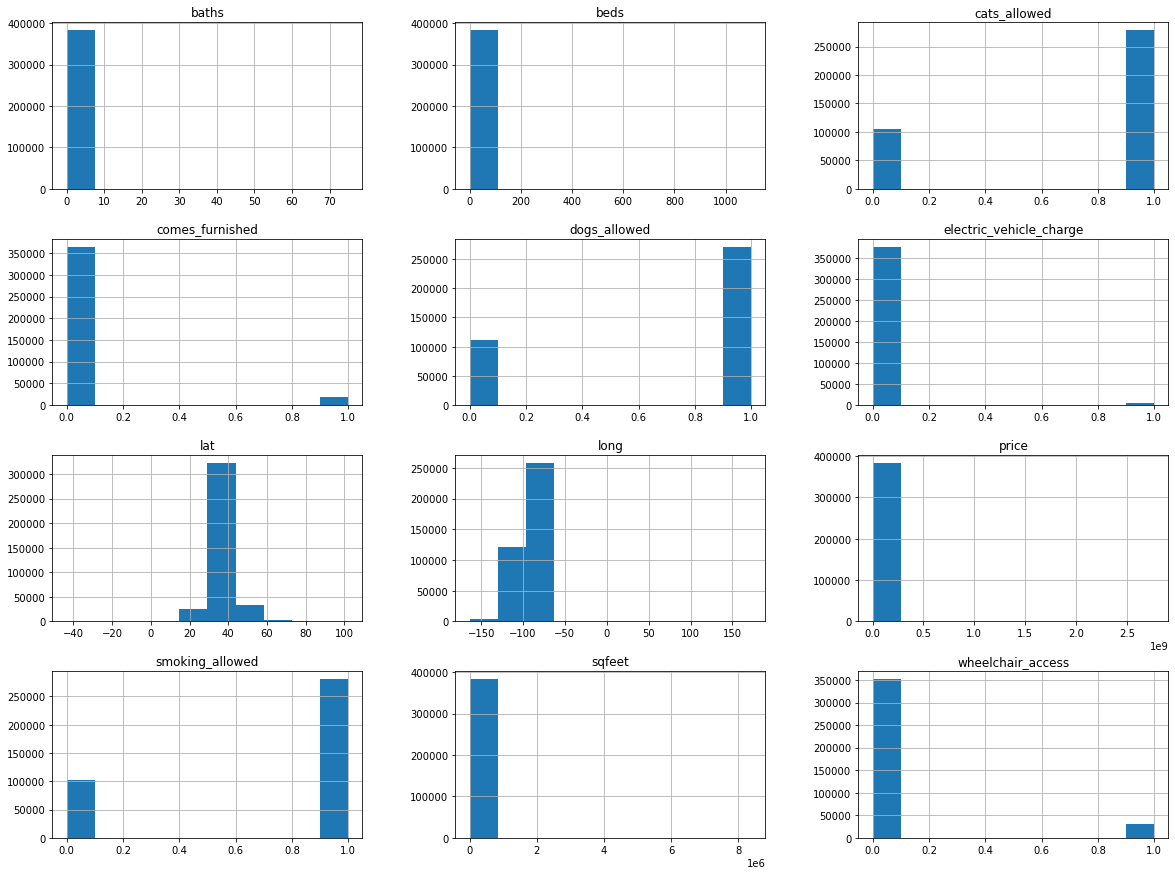

In [17]:
df1.hist(figsize=(20,15))

While some of these features may help with our predictions, we drop wheelchair access, electric vehicle charge, comes furnished to reduce the complexity of our model.

we combined dog and cats allowed then replot the hist.

In [18]:
df1=df1.drop(["wheelchair_access","electric_vehicle_charge","comes_furnished"],axis=1)

In [19]:
df1=df1.drop(["cats_allowed"],axis=1)
df1.rename(columns = {'dogs_allowed':'pets_allowed'}, inplace = True) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025CD1B9A9A0>,
      dtype=object)

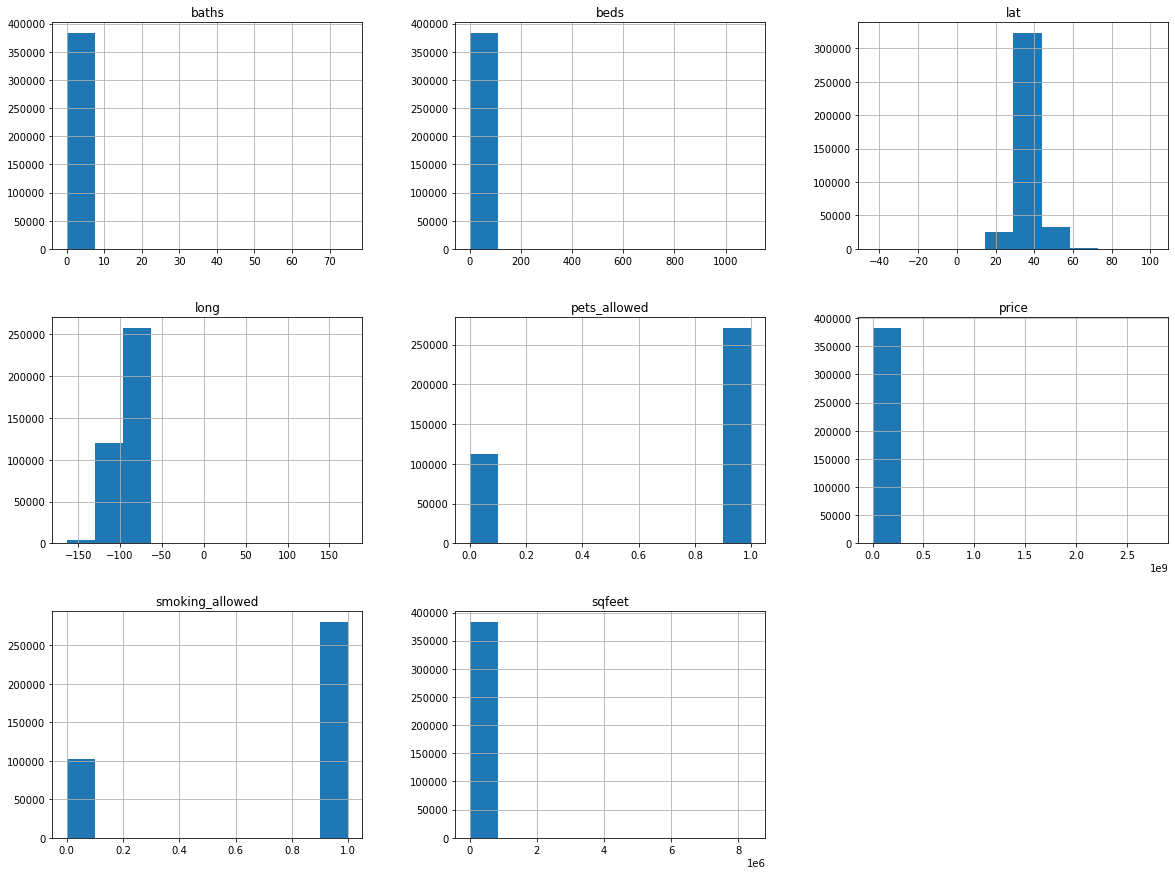

In [20]:
df1.hist(figsize=(20,15))

In [21]:
#Drop Land and assisted living, less than 10 values
df1.type.value_counts()


apartment          316744
house               32809
townhouse           15782
condo                6214
duplex               5020
manufactured         4235
cottage/cabin         854
loft                  692
flat                  528
in-law                171
land                    8
assisted living         2
Name: type, dtype: int64

In [22]:
type_remove = df1[df1['type'] == 'land'].index
df1.drop(index=type_remove, inplace=True)



In [23]:
df1.drop(index=df1[df1['type'] =='assisted living'].index, inplace=True)

In [24]:
df1.type.value_counts()

apartment        316744
house             32809
townhouse         15782
condo              6214
duplex             5020
manufactured       4235
cottage/cabin       854
loft                692
flat                528
in-law              171
Name: type, dtype: int64

In [25]:
df1.type.unique()

array(['apartment', 'condo', 'house', 'duplex', 'townhouse', 'loft',
       'manufactured', 'cottage/cabin', 'flat', 'in-law'], dtype=object)

In [26]:
df1.baths.unique()

array([ 2. ,  1. ,  3. ,  1.5,  2.5,  3.5,  0. ,  4.5,  5. ,  4. ,  6. ,
        5.5,  7. ,  6.5,  8.5, 75. ,  7.5,  8. , 25. ])

In [27]:
#bathroom outliers
df1[df1.baths>6]

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
15677,boulder,8000,house,8112,6,7.0,1,1,w/d in unit,detached garage,39.9611,-105.2050,co
26784,eastern CT,3995,house,4300,7,6.5,0,0,laundry in bldg,off-street parking,41.8620,-71.9672,ct
37586,florida keys,12000000,apartment,9000,7,8.5,0,0,w/d in unit,attached garage,25.9941,-80.1183,fl
69221,atlanta,499,house,7500,6,7.0,0,0,w/d in unit,attached garage,33.8420,-84.4127,ga
81630,hawaii,3200,house,5078,6,6.5,0,0,w/d in unit,carport,21.3453,-158.0870,hi
89776,chicago,2449,apartment,1000,1100,75.0,0,1,w/d in unit,carport,42.0195,-87.6650,il
90779,chicago,2449,apartment,1000,1100,75.0,0,1,w/d in unit,carport,42.0195,-87.6650,il
111395,"kansas city, MO",4500,house,6047,5,7.0,0,1,w/d hookups,attached garage,38.9660,-94.6342,ks
111586,"kansas city, MO",4200,house,7500,7,7.5,1,1,w/d in unit,attached garage,39.1736,-94.8668,ks
161911,minneapolis / st paul,1,apartment,1001,8,8.0,1,0,laundry in bldg,off-street parking,44.9585,-93.2970,mn


In [28]:
df2 = df1[df1.baths<6]

#check: # should return 0 
# df2[df2.baths>6] 

In [29]:
#remove prices above 10k because realistically people who can afford more than 10k a month can already buy their own house
#some of the data is already skewed
df2[df2.price>10000] 

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
1988,sacramento,95834,apartment,1060,2,2.0,0,1,w/d in unit,off-street parking,38.6560,-121.512,ca
4798,san diego,11995,apartment,2000,4,3.0,0,0,w/d in unit,off-street parking,32.7483,-117.217,ca
4922,san diego,11400,apartment,1969,3,3.0,1,0,w/d in unit,attached garage,32.7104,-117.151,ca
6445,santa barbara,15000,house,5386,6,4.5,0,1,w/d in unit,attached garage,34.4378,-119.616,ca
6607,santa barbara,11350,house,1019856,5,4.0,1,0,laundry in bldg,attached garage,34.4478,-119.703,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383429,palm springs,10010,house,4565,4,5.0,0,1,w/d in unit,off-street parking,33.7644,-116.340,ca
383744,palm springs,10060,condo,2836,2,3.0,0,1,w/d in unit,off-street parking,33.6685,-116.308,ca
383904,palm springs,15010,house,2632,3,2.0,0,1,w/d in unit,off-street parking,33.6685,-116.308,ca
383905,palm springs,10510,house,2442,3,4.0,0,1,w/d in unit,off-street parking,33.7643,-116.423,ca


In [30]:
df2 = df2[df2.price<10000]
df2[df2.price>10000] 


,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state


### Prices with 0 

In [31]:
df2[df2.price<100] #2200 outliers

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
2205,sacramento,0,apartment,500,1,1.0,0,1,w/d in unit,off-street parking,38.4718,-121.427,ca
3351,sacramento,0,apartment,500,1,1.0,0,1,w/d in unit,off-street parking,38.4718,-121.427,ca
3375,sacramento,0,apartment,500,1,1.0,0,1,w/d in unit,off-street parking,38.4718,-121.427,ca
3474,sacramento,0,apartment,500,1,1.0,0,1,w/d in unit,off-street parking,38.4718,-121.427,ca
3486,sacramento,0,apartment,500,1,1.0,0,1,w/d in unit,off-street parking,38.4718,-121.427,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381925,orange county,0,apartment,446,0,1.0,0,1,laundry in bldg,carport,33.7691,-117.885,ca
382005,orange county,0,apartment,750,1,1.0,1,1,laundry on site,carport,33.7524,-117.994,ca
382063,orange county,0,apartment,446,0,1.0,0,1,laundry in bldg,carport,33.7691,-117.885,ca
382349,orange county,0,apartment,446,0,1.0,0,1,laundry in bldg,carport,33.7691,-117.885,ca


In [32]:
df2 = df2[df2.price>100]
df2[df2.price<100]


,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state


In [33]:
df2[df2.price<300] #potential to remove later depending on model 

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
4,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
72,reno / tahoe,289,apartment,250,0,1.0,1,1,w/d in unit,off-street parking,39.5357,-119.805,ca
120,reno / tahoe,274,apartment,220,0,1.0,0,0,laundry on site,no parking,39.5268,-119.811,ca
144,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
178,reno / tahoe,274,apartment,220,0,1.0,0,0,laundry on site,no parking,39.5263,-119.813,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384942,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5483,-119.796,ca
384943,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
384946,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
384954,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca


In [34]:
df2.shape

(380525, 13)

In [35]:
df3 = df2.copy()

### IRC Code states that minimum sqfootage has to be minimum of 120sqfeet 

In [36]:
df3[df3.sqfeet<120]

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
546,reno / tahoe,817,apartment,70,1,1.0,1,1,laundry on site,off-street parking,39.5473,-119.756,ca
2134,sacramento,2025,apartment,13,3,2.0,1,0,w/d in unit,carport,38.4541,-121.412,ca
5571,san diego,1200,apartment,1,1,1.0,0,1,laundry on site,off-street parking,32.7560,-117.112,ca
5955,SF bay area,2650,apartment,100,3,1.5,0,0,w/d in unit,carport,37.5668,-121.972,ca
6090,san luis obispo,3400,apartment,65,3,2.5,1,0,w/d in unit,attached garage,35.4010,-120.864,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380339,orange county,2092,apartment,1,1,1.0,1,1,w/d in unit,detached garage,33.8701,-117.921,ca
381504,orange county,2445,apartment,2,2,2.0,1,1,w/d in unit,attached garage,33.8697,-117.831,ca
381765,orange county,900,house,72,1,1.0,0,1,no laundry on site,street parking,33.9331,-117.949,ca
382061,orange county,900,house,75,1,1.0,0,1,no laundry on site,street parking,33.9331,-117.949,ca


In [37]:
df3 = df3[df3.sqfeet>120]
df3[df3.sqfeet<120]

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state


In [38]:
df3[df3.sqfeet>5000]
# remove some outliers here, set the max to just 5000 

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
625,reno / tahoe,1995,house,17951,3,2.0,0,1,w/d hookups,attached garage,38.9166,-119.727,ca
929,reno / tahoe,1950,house,5081,3,2.5,1,0,w/d hookups,attached garage,39.5461,-119.724,ca
3481,sacramento,5500,house,5282,6,5.0,0,1,w/d hookups,off-street parking,38.4490,-121.194,ca
5517,san diego,2100,apartment,92037,1,1.0,1,1,w/d in unit,off-street parking,32.8455,-117.252,ca
6047,san luis obispo,6000,house,5100,5,4.0,0,0,w/d hookups,attached garage,35.0858,-120.505,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380218,monterey bay,3000,house,14000,3,2.0,0,1,w/d hookups,attached garage,36.9102,-121.757,ca
381763,orange county,9910,house,6190,6,5.0,0,1,w/d in unit,off-street parking,33.4615,-117.637,ca
381852,orange county,5510,house,5201,5,3.0,0,1,w/d in unit,off-street parking,33.9058,-117.786,ca
382276,orange county,6025,house,5452,4,4.0,1,1,w/d in unit,off-street parking,33.8841,-117.730,ca


In [39]:
df3 = df3[df3.sqfeet<5000]
df3[df3.sqfeet>5000]


,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state


In [40]:
## Beds

In [41]:
df3.beds.unique()

array([3, 2, 1, 0, 4, 5, 7, 6, 8], dtype=int64)

In [42]:
df3[df3.beds>4]

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
107,reno / tahoe,1125,apartment,1939,5,2.5,0,1,w/d in unit,off-street parking,39.0786,-120.173,ca
930,reno / tahoe,2495,house,3300,5,3.0,1,0,w/d hookups,attached garage,39.6077,-119.813,ca
1407,sacramento,2900,house,2900,7,3.0,0,1,w/d in unit,attached garage,38.4243,-121.437,ca
1789,sacramento,2250,house,2030,5,3.0,0,1,laundry on site,attached garage,38.6626,-121.483,ca
1923,sacramento,900,house,2340,6,2.5,0,0,w/d in unit,off-street parking,38.6383,-121.507,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383696,palm springs,6000,house,3000,6,5.0,0,0,w/d hookups,attached garage,33.7225,-116.377,ca
383747,palm springs,1000,apartment,1836,5,1.5,1,1,w/d in unit,off-street parking,33.7997,-116.986,ca
383769,palm springs,2195,house,2300,5,2.0,1,1,w/d hookups,attached garage,33.9460,-116.507,ca
383916,palm springs,3210,house,2426,5,3.0,1,1,w/d in unit,off-street parking,33.6685,-116.308,ca


In [43]:
# Only take bedrooms less than or equal to 4
df3 = df3[df3.beds<=4]


In [44]:
df3[df3.beds==0] #== studios, this looks good

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options,lat,long,state
4,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
36,reno / tahoe,875,apartment,550,0,1.0,0,0,laundry on site,off-street parking,39.4972,-119.776,ca
70,reno / tahoe,1095,apartment,435,0,1.0,0,1,laundry in bldg,off-street parking,39.2548,-120.046,ca
72,reno / tahoe,289,apartment,250,0,1.0,1,1,w/d in unit,off-street parking,39.5357,-119.805,ca
120,reno / tahoe,274,apartment,220,0,1.0,0,0,laundry on site,no parking,39.5268,-119.811,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384939,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
384942,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5483,-119.796,ca
384943,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca
384946,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking,39.5357,-119.805,ca


### Further Dimensionality reduction, remove regions with less than 100 data points

In [45]:
regions = df3['region'].value_counts()
regions
# drop listings where there are less than 100 listings to simplify training

jacksonville      4205
columbus          3638
jackson           3635
rochester         3624
fayetteville      3623
                  ... 
southwest MS        10
st louis             9
southwest TX         6
fort smith, AR       4
kansas city          3
Name: region, Length: 404, dtype: int64

In [46]:
regions_100 = regions[regions<100]

In [47]:
# df3['region'].value_counts()>100


In [48]:
df3.region = df3.region.apply(lambda x: 'other' if x in regions_100 else x)

In [49]:
df4 = df3.drop(df3[df3['region'] == 'other'].index)

df4.region.value_counts()>100

jacksonville         True
columbus             True
jackson              True
rochester            True
fayetteville         True
                     ... 
fort dodge           True
mansfield            True
st george            True
show low             True
central louisiana    True
Name: region, Length: 321, dtype: bool

In [50]:
# df4['region'].value_counts()

# Data Visualizations

Text(0.5, 1.0, 'Types of Rentals with the most squareefootage')

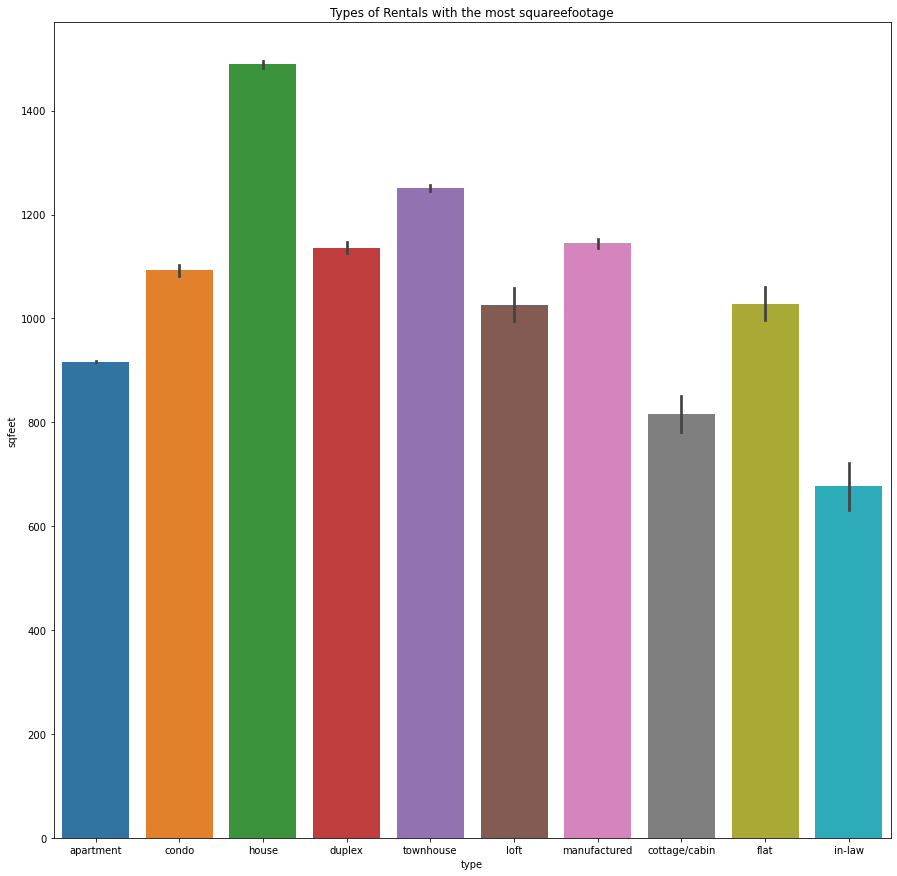

In [51]:
plt.figure(figsize=(15,15))
sns.barplot(x=df4.type, y=df4.sqfeet)
plt.title('Types of Rentals with the most squareefootage')


Text(0.5, 1.0, 'Types of Rentals with the highest cost')

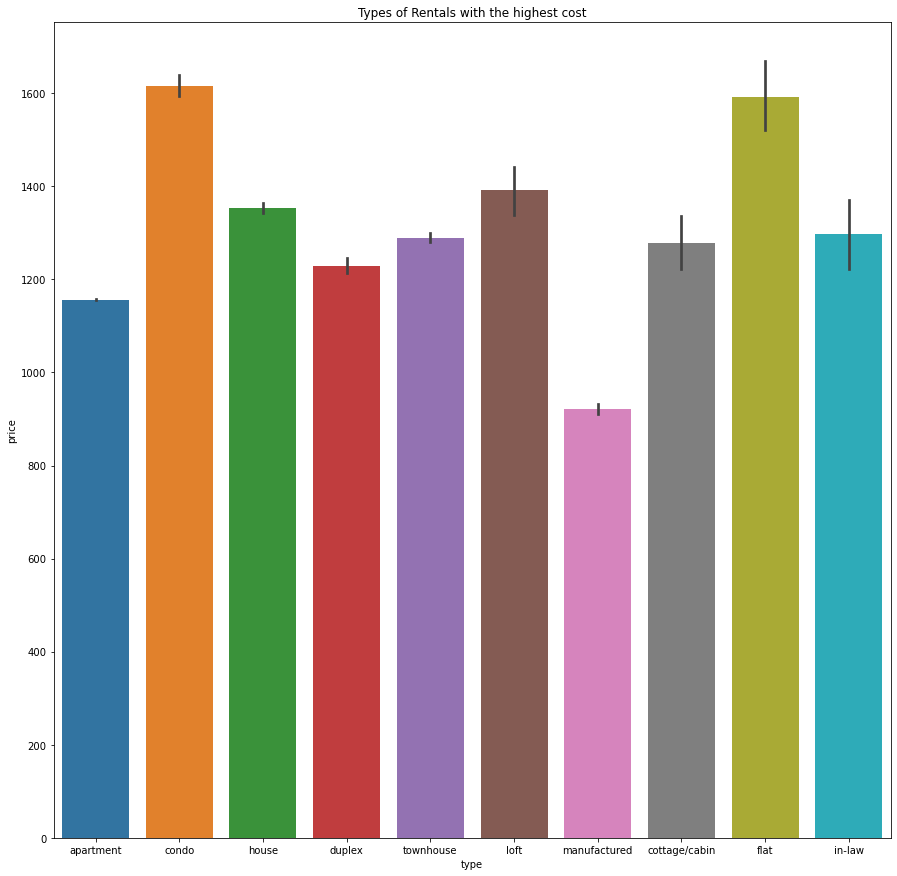

In [52]:
plt.figure(figsize=(15,15))
sns.barplot(x=df4.type, y=df4.price)
plt.title('Types of Rentals with the highest cost')

Text(0.5, 1.0, 'Does parking availability affect the cost of rent?')

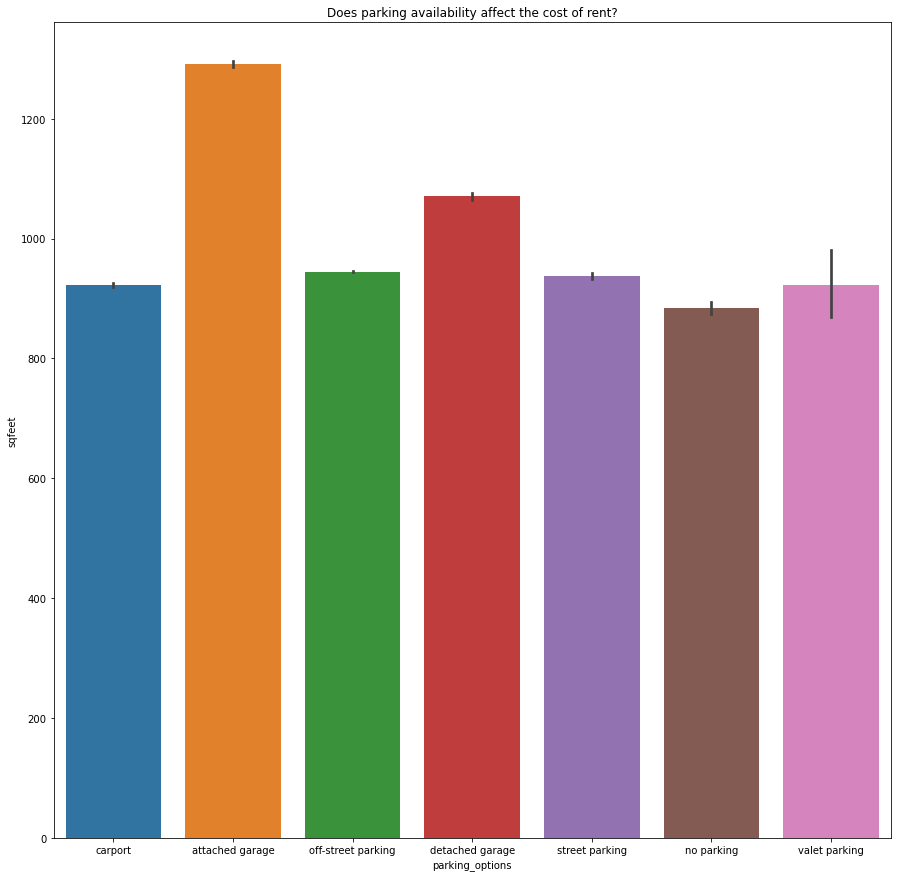

In [53]:
plt.figure(figsize=(15,15))
sns.barplot(x=df4.parking_options, y=df4.sqfeet)
plt.title('Does parking availability affect the cost of rent?')

Text(0.5, 1.0, 'Do pets affect price across america?')

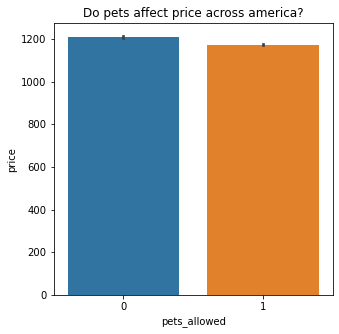

In [54]:
plt.figure(figsize=(5,5))
sns.barplot(x=df4.pets_allowed, y=df4.price)
plt.title('Do pets affect price across america?')

Text(0.5, 1.0, 'Which state has the highest mean rental prices')

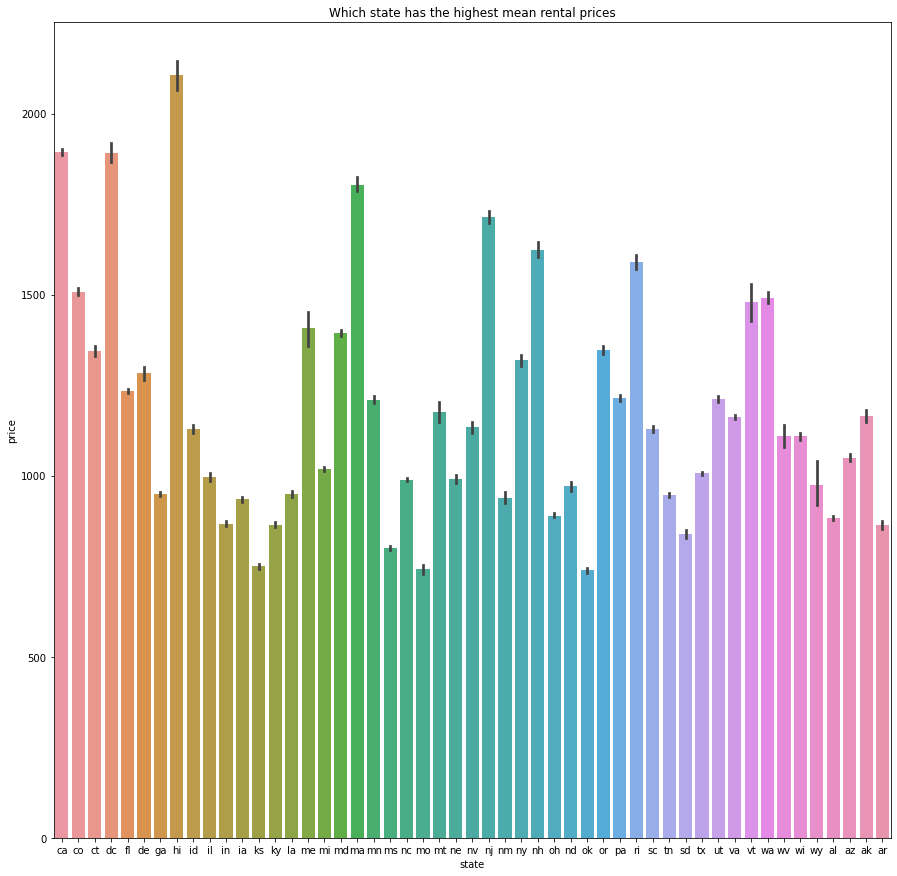

In [55]:
plt.figure(figsize=(15,15))
sns.barplot(x=df4.state, y=df4.price)
plt.title('Which state has the highest mean rental prices')

In [56]:
# df4.groupby(['region']).count().sort('price').index[-1]

In [57]:
df4.groupby('region')['price'].median().sort_values(ascending=False)[:10]

region
santa barbara      3000.0
SF bay area        2730.0
florida keys       2470.0
long island        2400.0
new york city      2400.0
los angeles        2295.0
ventura county     2215.0
boston             2200.0
san luis obispo    2150.0
high rockies       2100.0
Name: price, dtype: float64

In [58]:
df4.groupby('region')['price'].mean().sort_values(ascending=False)[:10]

region
santa barbara     3084.749153
SF bay area       2981.116586
new york city     2615.438108
los angeles       2485.650901
florida keys      2443.464126
long island       2380.555755
high rockies      2373.156627
boston            2352.946545
ventura county    2346.294555
monterey bay      2295.390374
Name: price, dtype: float64

In [59]:
top_ten = df4.groupby('region')['price'].median().sort_values(ascending=False)[:10]

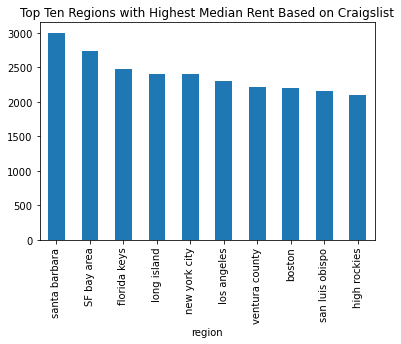

In [60]:
top_ten.plot(kind='bar', title='Top Ten Regions with Highest Median Rent Based on Craigslist')

In [61]:
top_ten = top_ten.reset_index()

In [62]:
top_ten

,region,price
0,santa barbara,3000.0
1,SF bay area,2730.0
2,florida keys,2470.0
3,long island,2400.0
4,new york city,2400.0
5,los angeles,2295.0
6,ventura county,2215.0
7,boston,2200.0
8,san luis obispo,2150.0
9,high rockies,2100.0


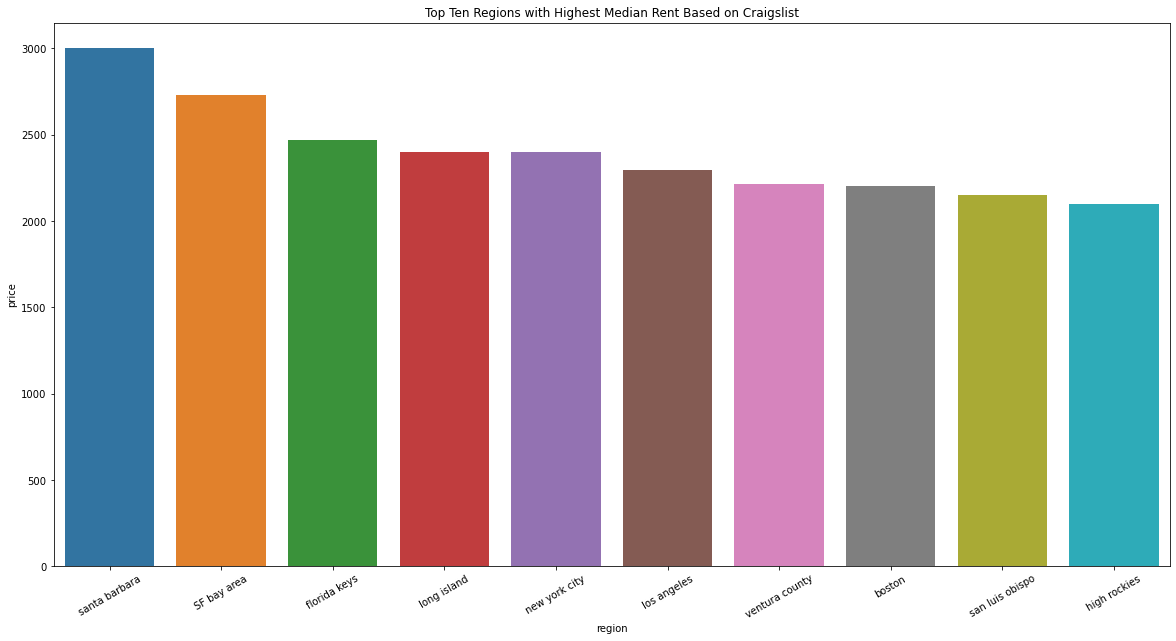

In [63]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=30)
plt.title('Top Ten Regions with Highest Median Rent Based on Craigslist')
sns.barplot(x=top_ten['region'],y=top_ten['price'])

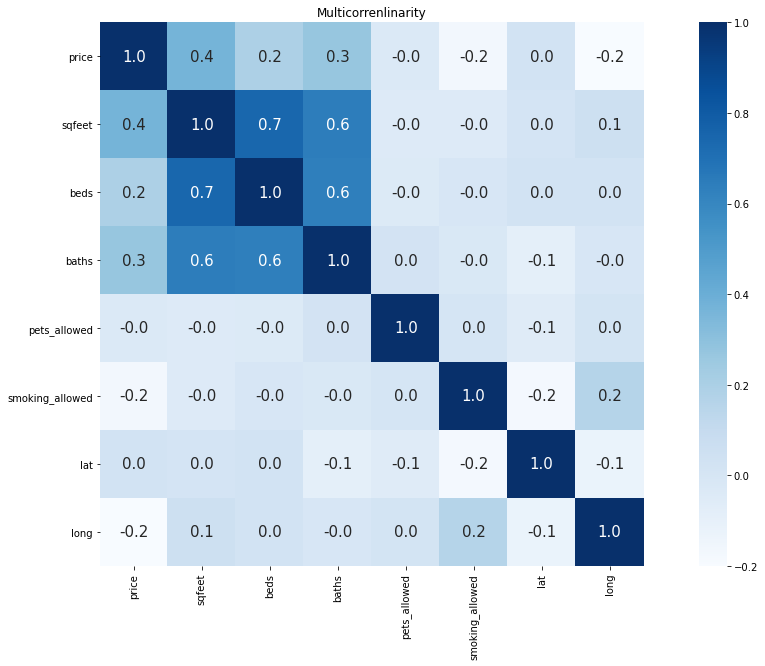

In [64]:
plt.figure(figsize=(20,10))
plt.title('Multicorrenlinarity')
sns.heatmap(df4.corr(), cbar=True, square= True,fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Blues')

As you might expect, there is not much correlation except with # of beds and baths because the more sqfootage you have, the more room you have to add additional bathrooms and baths.

In [65]:
#Saving some progress
df5 = df4.copy()

## Start of Model building

Some assumptions:
We are dropping the latitude, longitude and state because we want to predict rent based on a set of defined features and the geo coordinates will add additional complexity. Additionally, we are dropping state because there should be no overlapping region, as each region should be unique to the state.

2/1/2021: Note that it turns out that there are overlapping regions so we should not remove the state and include this in our model building and training

In [66]:

df5=df5.drop(["lat","long","state"],axis=1)

df5.shape

(372658, 10)

In [67]:
df5.head(3)

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
0,reno / tahoe,1148,apartment,1078,3,2.0,1,0,w/d in unit,carport
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,w/d hookups,carport
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,w/d in unit,attached garage


In [73]:
df6 = df5.copy()
df6.head(2)

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
0,reno / tahoe,1148,apartment,1078,3,2.0,1,0,w/d in unit,carport
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,w/d hookups,carport


In [74]:
df8 = df5.copy()
df8

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
0,reno / tahoe,1148,apartment,1078,3,2.0,1,0,w/d in unit,carport
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,w/d hookups,carport
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,w/d in unit,attached garage
3,reno / tahoe,1095,apartment,708,1,1.0,1,1,w/d in unit,carport
4,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking
...,...,...,...,...,...,...,...,...,...,...
384972,reno / tahoe,1295,apartment,957,2,2.0,1,1,w/d in unit,carport
384973,reno / tahoe,1549,apartment,1034,2,2.0,1,0,w/d in unit,off-street parking
384974,reno / tahoe,1249,apartment,840,2,1.0,1,1,laundry on site,off-street parking
384975,reno / tahoe,1429,apartment,976,2,2.0,1,1,w/d in unit,carport


In [75]:
# df4["state"]=le.fit_transform(df4["state"])
df6

,region,price,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
0,reno / tahoe,1148,apartment,1078,3,2.0,1,0,w/d in unit,carport
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,w/d hookups,carport
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,w/d in unit,attached garage
3,reno / tahoe,1095,apartment,708,1,1.0,1,1,w/d in unit,carport
4,reno / tahoe,289,apartment,250,0,1.0,1,1,laundry on site,off-street parking
...,...,...,...,...,...,...,...,...,...,...
384972,reno / tahoe,1295,apartment,957,2,2.0,1,1,w/d in unit,carport
384973,reno / tahoe,1549,apartment,1034,2,2.0,1,0,w/d in unit,off-street parking
384974,reno / tahoe,1249,apartment,840,2,1.0,1,1,laundry on site,off-street parking
384975,reno / tahoe,1429,apartment,976,2,2.0,1,1,w/d in unit,carport


## One Hot Encoding using column transformer

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [77]:
column_trans = make_column_transformer(
(OneHotEncoder(),['region','type','laundry_options','parking_options']),remainder='passthrough')

In [78]:
x=df6.drop(columns=["price"])
y=df6["price"]

In [79]:
x = column_trans.fit_transform(x).toarray()

In [80]:
x.shape

(372658, 348)

### Train Test Split

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0)

In [ ]:
# x_train.shape()

In [83]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


### Train our model using Linear Regression first just to get fast baseline estimate of a simple model

In [84]:
lr_clf = LinearRegression()
lr_clf.fit(x_train,y_train)
lr_clf.score(x_test,y_test)

0.6606543547584811

In [87]:
def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
    }
    scores = []
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])



In [89]:
find_best_model_using_gridsearchcv(x,y) 


,model,best_score,best_params
0,linear_regression,0.662116,{'normalize': False}
1,lasso,0.557975,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.730536,"{'criterion': 'mse', 'splitter': 'random'}"


None of these models predicted very well, let's try using a Random Forest Regressor, we will use a grid search again to get the best model for our predictions

In [ ]:
# If we were just making one instance of a default Random Forest Regressor:
# rf_clf = RandomForestRegressor()
# rf_clf.fit(x_train,y_train)
# rf_clf.score(x_test,y_test)

### Hyper tuning Random Forest and Cross Validating with Gridsearch

**Do not** run ths gridsearch at home as it is very expensive and will take over a day to run the gridsearch. I did it for you so you can just look at the results in the csv. A downside to this model is that RandomForest takes a long time to train since we have  over 370,000 records and 349 categorical features we are training it on. Even just one instance of a training will take hours on the CPU as it preforms matrix calculations. This would have been easier if we just ran it on one region, which you can do at home. Just drop the other regions in your dataframe. This was done purely as a side project and to test the limits of my CPU and resources. You can look at the time it took for each instance to run within the provided CSV.

In [96]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)

gridsearch = GridSearchCV(RandomForestRegressor(warm_start=True, n_jobs=-1),{
    'n_estimators':[90, 100, 150],
    'oob_score' : [True, False],
    'min_impurity_decrease':[0, .25, 1]
},cv=cv)



In [97]:
gridsearch.fit(x, y)

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, warm_start=True),
             param_grid={'min_impurity_decrease': [0, 0.25, 1],
                         'n_estimators': [90, 100, 150],
                         'oob_score': [True, False]})

In [98]:
gridsearch.cv_results_

{'mean_fit_time': array([1974.81383745, 1947.62862221, 2040.67599567, 1937.21129815,
        2917.44835981, 2900.32530785, 1751.49001296, 1855.72506364,
        1968.33166774, 1942.76784952, 2630.18886312, 3561.00702381,
        2266.18220949, 1894.08255545, 1666.76366576, 1647.91212034,
        2493.98917135, 2470.92663519]),
 'std_fit_time': array([ 14.30622149,   7.92978417,  47.01363967,  13.81009397,
         26.04416014,  16.41065688,   8.89691213,  22.3509528 ,
         10.5062304 ,  13.92469118,  27.96468878, 477.88902539,
         83.81637473, 408.28125852,   9.75604778,   7.30925268,
         18.90285401,  13.84337282]),
 'mean_score_time': array([1.47359284, 1.43198148, 1.45910962, 1.41429122, 2.10205984,
        2.13398671, 1.05265133, 1.10324105, 1.18472902, 1.15882881,
        1.49800626, 2.31221128, 1.19508489, 0.91247336, 0.75898139,
        0.76953983, 1.13802751, 1.12110774]),
 'std_score_time': array([0.01719626, 0.00484996, 0.05501591, 0.01341026, 0.05537511,
      

In [101]:
gridsearch.best_score_

0.8220969084146441

In [102]:
gridsearch.best_params_

{'min_impurity_decrease': 0, 'n_estimators': 150, 'oob_score': False}

In [103]:
results = pd.DataFrame(gridsearch.cv_results_)

In [104]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_impurity_decrease,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1974.813837,14.306221,1.473593,0.017196,0,90,True,"{'min_impurity_decrease': 0, 'n_estimators': 9...",0.821275,0.819813,0.822918,0.821335,0.001269,6
1,1947.628622,7.929784,1.431981,0.004850,0,90,False,"{'min_impurity_decrease': 0, 'n_estimators': 9...",0.822178,0.818375,0.825310,0.821954,0.002835,2
2,2040.675996,47.013640,1.459110,0.055016,0,100,True,"{'min_impurity_decrease': 0, 'n_estimators': 1...",0.820984,0.818612,0.824422,0.821339,0.002385,5
3,1937.211298,13.810094,1.414291,0.013410,0,100,False,"{'min_impurity_decrease': 0, 'n_estimators': 1...",0.822327,0.818739,0.824280,0.821782,0.002295,4
4,2917.448360,26.044160,2.102060,0.055375,0,150,True,"{'min_impurity_decrease': 0, 'n_estimators': 1...",0.821813,0.818966,0.825034,0.821937,0.002479,3
5,2900.325308,16.410657,2.133987,0.045238,0,150,False,"{'min_impurity_decrease': 0, 'n_estimators': 1...",0.822817,0.818556,0.824917,0.822097,0.002646,1
6,1751.490013,8.896912,1.052651,0.017050,0.25,90,True,"{'min_impurity_decrease': 0.25, 'n_estimators'...",0.820287,0.817298,0.821998,0.819861,0.001942,11
7,1855.725064,22.350953,1.103241,0.008482,0.25,90,False,"{'min_impurity_decrease': 0.25, 'n_estimators'...",0.820514,0.817750,0.822723,0.820329,0.002034,9
8,1968.331668,10.506230,1.184729,0.011646,0.25,100,True,"{'min_impurity_decrease': 0.25, 'n_estimators'...",0.821293,0.817232,0.822443,0.820323,0.002235,10
9,1942.767850,13.924691,1.158829,0.013962,0.25,100,False,"{'min_impurity_decrease': 0.25, 'n_estimators'...",0.820546,0.816329,0.822297,0.819724,0.002505,12


In [105]:
results.to_csv('random_forest_gridsearch_results.csv', index=False)

All of the scores are around 80-82%, we can build our model using the best params, but let's also test some metrics to see how good is our best model, right now: n_estimators = 150.
Gridsearch defaults to using the best model's params to make its predictions.

## Validations

In [106]:
y_pred=gridsearch.predict(x_test)
y_pred

array([ 912.3136509 , 1074.52638917, 1727.47333333, ..., 1606.13169027,
       1263.17852333, 1138.92619271])

In [108]:
from sklearn import metrics
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.9645658193776752
Adjusted R^2: 0.9645244088763384
MAE: 44.791596843901395
MSE: 11848.921629628285
RMSE: 108.85275205353462


Overall, our metrics suggest that the errors are relatively good except the Mean squared error. MSE is very sensitive to outliers and therefore would suggest that there may have been some outliers within our data that got overlooked despite our efforts at cleaning the data. For our R^2 errors are close to 1, but ideally I'd like it to be higher than 96%.

Regarding the MAE, which treats all errors equally, the suggested fluctuation in price is about $50/month which suggest that it would be good enough to move forward with. 

For the purpose of this project I won't be going further to clean the data due to time constraints and I think based on our scores, it is good enough for a personal project. Additionally, as long as we know the models biases and limitations we can still use it to make predictions and know what it is good at.

Because we finished training the model and testing it with Gridsearch and metrics, let's start exporting everything so we worked on so far and then we will retrain the model with the full dataset and start building a pipeline and predictor function to take in our inputs

### Exporting all our values and saving the progress we made and exporting categorical values to be later used in our application

In [109]:
df6.to_csv('cleaned_housing.csv', index=False)

In [113]:
state_region = df4.groupby('state')['region'].unique().apply(list).to_dict()
state_region

{'ak': ['anchorage / mat-su', 'fairbanks'],
 'al': ['auburn',
  'birmingham',
  'huntsville / decatur',
  'dothan',
  'mobile',
  'montgomery',
  'tuscaloosa'],
 'ar': ['little rock', 'fayetteville', 'fort smith', 'jonesboro'],
 'az': ['phoenix',
  'flagstaff / sedona',
  'tucson',
  'prescott',
  'yuma',
  'mohave county',
  'show low',
  'sierra vista'],
 'ca': ['reno / tahoe',
  'sacramento',
  'visalia-tulare',
  'santa barbara',
  'SF bay area',
  'ventura county',
  'san diego',
  'san luis obispo',
  'stockton',
  'santa maria',
  'yuba-sutter',
  'bakersfield',
  'fresno / madera',
  'hanford-corcoran',
  'humboldt county',
  'inland empire',
  'los angeles',
  'gold country',
  'chico',
  'modesto',
  'orange county',
  'merced',
  'palm springs',
  'monterey bay',
  'redding'],
 'co': ['boulder',
  'colorado springs',
  'denver',
  'fort collins / north CO',
  'western slope',
  'high rockies',
  'pueblo'],
 'ct': ['northwest CT', 'eastern CT', 'hartford', 'new haven'],
 'dc'

In [117]:
laundry = list(df4.laundry_options.unique())

laundry

['w/d in unit',
 'w/d hookups',
 'laundry on site',
 'laundry in bldg',
 'no laundry on site']

In [118]:
parking = list(df4.parking_options.unique())
parking

['carport',
 'attached garage',
 'off-street parking',
 'detached garage',
 'street parking',
 'no parking',
 'valet parking']

In [119]:
house_type = list(df4.type.unique())
house_type

['apartment',
 'condo',
 'house',
 'duplex',
 'townhouse',
 'loft',
 'manufactured',
 'cottage/cabin',
 'flat',
 'in-law']

In [120]:
ammenity = {
    'house_type' :[x for x in house_type],
    'parking':[x for x in parking],
    'laundry':[x for x in laundry],
}

ammenity

{'house_type': ['apartment',
  'condo',
  'house',
  'duplex',
  'townhouse',
  'loft',
  'manufactured',
  'cottage/cabin',
  'flat',
  'in-law'],
 'parking': ['carport',
  'attached garage',
  'off-street parking',
  'detached garage',
  'street parking',
  'no parking',
  'valet parking'],
 'laundry': ['w/d in unit',
  'w/d hookups',
  'laundry on site',
  'laundry in bldg',
  'no laundry on site']}

In [121]:
import json
with open('ammenity.json', 'w') as f:
    f.write(json.dumps(ammenity))
with open('state_region.json', 'w') as f:
    f.write(json.dumps(state_region))

## Build a Pipeline

In [122]:
rf = RandomForestRegressor(n_estimators=150, min_impurity_decrease=0, oob_score=False)
# already made in line 77: 
# column_trans = make_column_transformer(
# (OneHotEncoder(),['region','type','laundry_options','parking_options']),remainder='passthrough')

In [123]:
from sklearn.pipeline import make_pipeline

In [127]:
new_x=df6.drop(columns=["price"])
new_y=df6["price"]

In [128]:
pipe = make_pipeline(column_trans, rf)
pipe.fit(new_x,new_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['region', 'type',
                                                   'laundry_options',
                                                   'parking_options'])])),
                ('randomforestregressor',
                 RandomForestRegressor(min_impurity_decrease=0,
                                       n_estimators=150))])


## Making Predictions with Pipeline

Pipeline is created.
Test the pipeline, get a random sample and make a prediction, and learning how to use the pipeline predict.
Our pipeline takes in a dataframe which then transforms the inputs to preform one hot encoding and then run a prediction through the random forest model. This way the pipeline handles all the preprocessing steps for us so it will be easier to use in a production enviornment.

In [130]:
x_sample = new_x.sample(1, random_state=1)
x_sample

,region,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
63790,tampa bay area,condo,900,1,1.0,1,0,w/d in unit,off-street parking


In [131]:
pipe.predict(x_sample)

array([1152.59247312])

In [132]:
test = np.array(['reno / tahoe', 'apartment', 2000, 2, 2, 0, 0, 'w/d in unit', 'carport'])
test = np.expand_dims(test, axis=0)
test_df = pd.DataFrame(test, columns=['region','type','sqfeet','beds','baths', 'pets_allowed','smoking_allowed','laundry_options', 'parking_options'])
test_df

,region,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
0,reno / tahoe,apartment,2000,2,2,0,0,w/d in unit,carport


In [133]:
pipe.predict(test_df)

array([1976.39111111])

In [135]:
test2 = new_x.sample(20, random_state=1)
test2.head()

,region,type,sqfeet,beds,baths,pets_allowed,smoking_allowed,laundry_options,parking_options
63790,tampa bay area,condo,900,1,1.0,1,0,w/d in unit,off-street parking
344180,madison,apartment,904,2,1.0,1,1,laundry in bldg,off-street parking
243702,eugene,apartment,1019,2,2.0,1,0,w/d in unit,off-street parking
66481,treasure coast,house,2100,3,0.0,0,0,w/d in unit,attached garage
354830,tuscaloosa,apartment,944,2,1.0,1,1,w/d hookups,off-street parking


In [136]:
pipe.predict(test2)

array([1152.59247312,  936.65526447, 2147.38904361, 2520.7       ,
        735.        ,  731.13333333,  999.18666667,  604.3       ,
        559.68846886, 1289.        , 1378.22478003,  881.32142857,
       1905.08222222, 1314.2217909 , 1485.        , 1270.47037037,
       1448.36058257,  518.        ,  823.        ,  834.22280702])

### Model is created let's save the pipeline as a pickle file

In [137]:
import pickle
with open('pipeline.pickle','wb') as f:
    pickle.dump(pipe, f)

## Create a Predictor Function

In [138]:

model = None

def predict(reg, typ, sqfeet, bed, baths, pets, smoking, laundry, parking):
    
    global model
    if model is None:
        with open('pipeline.pickle', 'rb') as f:
            model = pickle.load(f)
    
    sqfeet = int(sqfeet)
    
    beds = int(bed)
    baths = int(baths)
    if pets == 'yes':
        pets = 1
    else:
        pets = 0
        
    if smoking == 'yes':
        smoking = 1
    else:
        smoking = 0
    
    
    x1 = np.array([reg,typ,sqfeet, beds, baths,pets, smoking, laundry, parking])
    x1 = np.expand_dims(x1, axis=0)
    x2 = pd.DataFrame(x1, columns=['region','type','sqfeet',
                                 'beds','baths', 
                                 'pets_allowed','smoking_allowed',
                                 'laundry_options', 'parking_options'])
    
    if sqfeet < 500 or sqfeet > 5000:
        return f'{round(model.predict(x2)[0])}, but this is likely inaccurate, please use a higher square footage'
    
    
    return round(model.predict(x2)[0])

### Using our Predict function

In [139]:
predict('boston', 'apartment', 1000, 2, 2, 'yes', 'no', 'w/d in unit', 'no parking')

2226.0

In [140]:
predict('boston', 'apartment', 850, 2, 2, 'yes', 'no', 'w/d in unit', 'no parking')

2593.0

In [141]:
predict('boston', 'house', 2000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

2287.0

In [142]:
predict('SF bay area', 'house', 2000, 2, 2, 'yes', 'no', 'w/d in unit', 'attached garage')

4356.0

In [143]:
predict('albany', 'house', 2000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

2064.0

In [144]:
predict('jacksonville', 'apartment', 850, 0, 1, 'yes', 'no', 'w/d in unit', 'no parking')  

1216.0

In [145]:
predict('wilmington', 'apartment', 850, 0, 1, 'yes', 'no', 'w/d in unit', 'no parking')

1209.0

In [146]:
predict('jacksonville', 'house', 2000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

1721.0

In [147]:
predict('albany', 'house', 1000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

1216.0

In [148]:
predict('jacksonville', 'apartment', 1000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

1140.0

In [149]:
predict('jacksonville', 'house', 1000, 2, 2, 'yes', 'no', 'w/d in unit', 'carport')

1188.0

In [150]:
predict('SF bay area', 'apartment', 100, 0, 1, 'yes', 'no', 'w/d in unit', 'no parking')

'2088.0, but this is likely inaccurate, please use a higher square footage'

In [153]:
predict('SF bay area', 'house', 3000, 0, 1, 'yes', 'no', 'w/d in unit', 'attached garage')

5462.0

In [154]:
predict('SF bay area', 'house', 3001, 0, 1, 'yes', 'no', 'w/d in unit', 'attached garage')

'5462.0, but this is likely inaccurate, please use a higher square footage'

In [156]:
predict('SF bay area', 'house', 2500, 0, 1, 'yes', 'no', 'w/d in unit', 'attached garage')

4739.0

In [165]:
predict('SF bay area', 'apartment', 3000, 0, 1, 'yes', 'no', 'w/d in unit', 'no parking')

6403.0

In [167]:
predict('SF bay area', 'apartment', 6001, 0, 1, 'yes', 'no', 'w/d in unit', 'no parking')

'6401.0, but this is likely inaccurate, please use a higher square footage'

# Conclusions and Limitations


## Limitations and Flaws
- model could be a lot better; 82% accuracy
- reliant on craigslist data being 'good'
- data is slightly older as it was last updated in June 2020
- Extremely expensive in terms of memory utilization and training time, there are other ways to train to the dataset possible to try and building a neural network out of this dataset intsead of relying on a random forest approach

## Things to improve
- Do more data cleaning, possibly remove the null values from parking options
- Remove further outliers from the price points, possibly remove prices under $300

## Other Features that can be added to improve this project and make it more dynamic
- build a webscrapper to update and pull new data
- set some kind of check back to the original dataset for when it updates, redownload the data and rerun the same tests and retrain the model so that it can learn again OR add a native bayes to update the model
- connect State with regions for dropdown menu with the Flask Application
- retrain the data with states tied to the regions, as not all regions are not unique
- turn the model into a REST api for other people to use the model
- ~record user input to see where and what trends people are searching and curious for; if they also want to know how much they want to pay for rent and add that data to a db to learn from it - maybe add google analytics~

#### Important note as of 3/5/2021: The model used in the current LIVE rent predictor is slightly different than the one built here in this notebook; there was slightly more outlier removal and dimensionality reduction than what is shown here.
- What was different from the model used in production was that there was an additional step with removing outliers. I removed baths >5 instead of 6. Additionally, beds removed were <4, instead of <=4. Thus, the model was trained on 361,775 (this model was trained on 372658 -new_x.shape) records. Doing it again, I would use this pipeline however due to memory limits with google's system, we stick to the 1.0 version. The correct model is the one shown on this version.
- Additionally the previous model's parameters were: RandomForestRegressor(n_estimators=150, oob_score=True, min_impurity_decrease=.25, n_jobs=-1), gridsearch showed us that we do not need a min_impurity_descrease or oob_score. The score here was 81.53%
- There is an effort to update the pipeline to better represent the model in the live version, however that may not be implmented 